# Stock Price Prediction Using RNNs

## Objective
The objective of this is to try and predict the stock prices using historical data from four companies IBM (IBM), Google (GOOGL), Amazon (AMZN), and Microsoft (MSFT).

We use four different companies because they belong to the same sector: Technology. Using data from all four companies may improve the performance of the model. This way, we can capture the broader market sentiment.


## Business Value

Data related to stock markets lends itself well to modeling using RNNs due to its sequential nature. We can keep track of opening prices, closing prices, highest prices, and so on for a long period of time as these values are generated every working day. The patterns observed in this data can then be used to predict the future direction in which stock prices are expected to move. Analyzing this data can be interesting in itself, but it also has a financial incentive as accurate predictions can lead to massive profits.

## **1 Data Loading and Preparation**

#### **Import Necessary Libraries**

In [19]:
# Import libraries
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

### **1.1 Data Aggregation**

As we are using the stock data for four different companies, we need to create a new DataFrame that contains the combined data from all four data frames. We will create a function that takes in a list of the file names for the four CSV files, and returns a single data frame. This function performs the following tasks:
- Extract stock names from file names
- Read the CSV files as data frames
- Append the stock names into the columns of their respective data frames
- Drop unnecessary columns
- Join the data frames into one.

In [20]:
pth = "/kaggle/input/"

In [21]:
for dirname, _, filenames in os.walk(pth):
    for filename in filenames:
        print(filename)

AMZN_stocks_data.csv
GOOGL_stocks_data.csv
IBM_stocks_data.csv
MSFT_stocks_data.csv


In [22]:
# Define a function to load data and aggregate them

def data_loader(pth):
    all_dataframes = []
    columns_to_keep = ['Date', 'Open', 'Close', 'High', 'Low', 'Volume', 'Name']
    df = pd.DataFrame()
    i = 1
    
    for dirname, _, filenames in os.walk(pth):
        for filename in filenames:
            #Reading the dataframe
            df_temp = pd.read_csv(os.path.join(dirname, filename))

            #extracting the name of the company
            company_name = filename.split("_")[0]

            #checking if all the columns we want are present in the df
            for col in columns_to_keep:
                if col not in df_temp.columns:
                    print(f"{col} not present in {company_name} and NAs will be added for it.")
                    df_temp[col] = np.nan

            #appending all the dataframes into a list
            if i == 1:
                df["Date"] = df_temp["Date"]
                df = pd.merge(df, df_temp, how = "inner", on = "Date")
            else:
                df = pd.merge(df, df_temp, how = 'inner', on = "Date", suffixes = ("", f"_{company_name}"))
            i += 1
    return df

In [23]:
df = data_loader(pth)
df

,Date,Open,High,Low,Close,Volume,Name,Open_GOOGL,High_GOOGL,Low_GOOGL,...,Low_IBM,Close_IBM,Volume_IBM,Name_IBM,Open_MSFT,High_MSFT,Low_MSFT,Close_MSFT,Volume_MSFT,Name_MSFT
0,2006-01-03,47.47,47.85,46.25,47.58,7582127,AMZN,211.47,218.05,209.32,...,80.81,82.06,11715200,IBM,26.25,27.00,26.10,26.84,79974418,MSFT
1,2006-01-04,47.48,47.73,46.69,47.25,7440914,AMZN,222.17,224.70,220.09,...,81.33,81.95,9840600,IBM,26.77,27.08,26.77,26.97,57975661,MSFT
2,2006-01-05,47.16,48.20,47.11,47.65,5417258,AMZN,223.22,226.00,220.97,...,81.00,82.50,7213500,IBM,26.96,27.13,26.91,26.99,48247610,MSFT
3,2006-01-06,47.97,48.58,47.32,47.87,6154285,AMZN,228.66,235.49,226.85,...,83.41,84.95,8197400,IBM,26.89,27.00,26.49,26.91,100969092,MSFT
4,2006-01-09,46.55,47.10,46.40,47.08,8945056,AMZN,233.44,236.94,230.70,...,83.38,83.73,6858200,IBM,26.93,27.07,26.76,26.86,55627836,MSFT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3014,2017-12-22,1172.08,1174.62,1167.83,1168.36,1585054,AMZN,1070.00,1071.72,1067.64,...,151.50,152.50,2990583,IBM,85.40,85.63,84.92,85.51,14145841,MSFT
3015,2017-12-26,1168.36,1178.32,1160.55,1176.76,2005187,AMZN,1068.64,1068.86,1058.64,...,152.50,152.83,2479017,IBM,85.31,85.53,85.03,85.40,9891237,MSFT
3016,2017-12-27,1179.91,1187.29,1175.61,1182.26,1867208,AMZN,1066.60,1068.27,1058.38,...,152.61,153.13,2149257,IBM,85.65,85.98,85.22,85.71,14678025,MSFT
3017,2017-12-28,1189.00,1190.10,1184.38,1186.10,1841676,AMZN,1062.25,1064.84,1053.38,...,153.20,154.04,2687624,IBM,85.90,85.93,85.55,85.72,10594344,MSFT


In [24]:
df = df.rename(columns={
                'Open': 'Open_AMZN',
                'Close': 'Close_AMZN',
                'High': 'High_AMZN',
                'Low': 'Low_AMZN',
                'Volume': 'Volume_AMZN',
                'Name': 'Name_AMZN'
                })
df

,Date,Open_AMZN,High_AMZN,Low_AMZN,Close_AMZN,Volume_AMZN,Name_AMZN,Open_GOOGL,High_GOOGL,Low_GOOGL,...,Low_IBM,Close_IBM,Volume_IBM,Name_IBM,Open_MSFT,High_MSFT,Low_MSFT,Close_MSFT,Volume_MSFT,Name_MSFT
0,2006-01-03,47.47,47.85,46.25,47.58,7582127,AMZN,211.47,218.05,209.32,...,80.81,82.06,11715200,IBM,26.25,27.00,26.10,26.84,79974418,MSFT
1,2006-01-04,47.48,47.73,46.69,47.25,7440914,AMZN,222.17,224.70,220.09,...,81.33,81.95,9840600,IBM,26.77,27.08,26.77,26.97,57975661,MSFT
2,2006-01-05,47.16,48.20,47.11,47.65,5417258,AMZN,223.22,226.00,220.97,...,81.00,82.50,7213500,IBM,26.96,27.13,26.91,26.99,48247610,MSFT
3,2006-01-06,47.97,48.58,47.32,47.87,6154285,AMZN,228.66,235.49,226.85,...,83.41,84.95,8197400,IBM,26.89,27.00,26.49,26.91,100969092,MSFT
4,2006-01-09,46.55,47.10,46.40,47.08,8945056,AMZN,233.44,236.94,230.70,...,83.38,83.73,6858200,IBM,26.93,27.07,26.76,26.86,55627836,MSFT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3014,2017-12-22,1172.08,1174.62,1167.83,1168.36,1585054,AMZN,1070.00,1071.72,1067.64,...,151.50,152.50,2990583,IBM,85.40,85.63,84.92,85.51,14145841,MSFT
3015,2017-12-26,1168.36,1178.32,1160.55,1176.76,2005187,AMZN,1068.64,1068.86,1058.64,...,152.50,152.83,2479017,IBM,85.31,85.53,85.03,85.40,9891237,MSFT
3016,2017-12-27,1179.91,1187.29,1175.61,1182.26,1867208,AMZN,1066.60,1068.27,1058.38,...,152.61,153.13,2149257,IBM,85.65,85.98,85.22,85.71,14678025,MSFT
3017,2017-12-28,1189.00,1190.10,1184.38,1186.10,1841676,AMZN,1062.25,1064.84,1053.38,...,153.20,154.04,2687624,IBM,85.90,85.93,85.55,85.72,10594344,MSFT


In [25]:
#Lets drop the name columns, since we have the name factored into the column headers
name_cols = []
for col in df:
    if "Name" in col:
        name_cols.append(col)
df.drop(name_cols, axis = 1, inplace = True)
df

,Date,Open_AMZN,High_AMZN,Low_AMZN,Close_AMZN,Volume_AMZN,Open_GOOGL,High_GOOGL,Low_GOOGL,Close_GOOGL,...,Open_IBM,High_IBM,Low_IBM,Close_IBM,Volume_IBM,Open_MSFT,High_MSFT,Low_MSFT,Close_MSFT,Volume_MSFT
0,2006-01-03,47.47,47.85,46.25,47.58,7582127,211.47,218.05,209.32,217.83,...,82.45,82.55,80.81,82.06,11715200,26.25,27.00,26.10,26.84,79974418
1,2006-01-04,47.48,47.73,46.69,47.25,7440914,222.17,224.70,220.09,222.84,...,82.20,82.50,81.33,81.95,9840600,26.77,27.08,26.77,26.97,57975661
2,2006-01-05,47.16,48.20,47.11,47.65,5417258,223.22,226.00,220.97,225.85,...,81.40,82.90,81.00,82.50,7213500,26.96,27.13,26.91,26.99,48247610
3,2006-01-06,47.97,48.58,47.32,47.87,6154285,228.66,235.49,226.85,233.06,...,83.95,85.03,83.41,84.95,8197400,26.89,27.00,26.49,26.91,100969092
4,2006-01-09,46.55,47.10,46.40,47.08,8945056,233.44,236.94,230.70,233.68,...,84.10,84.25,83.38,83.73,6858200,26.93,27.07,26.76,26.86,55627836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3014,2017-12-22,1172.08,1174.62,1167.83,1168.36,1585054,1070.00,1071.72,1067.64,1068.86,...,151.82,153.00,151.50,152.50,2990583,85.40,85.63,84.92,85.51,14145841
3015,2017-12-26,1168.36,1178.32,1160.55,1176.76,2005187,1068.64,1068.86,1058.64,1065.85,...,152.51,153.86,152.50,152.83,2479017,85.31,85.53,85.03,85.40,9891237
3016,2017-12-27,1179.91,1187.29,1175.61,1182.26,1867208,1066.60,1068.27,1058.38,1060.20,...,152.95,153.18,152.61,153.13,2149257,85.65,85.98,85.22,85.71,14678025
3017,2017-12-28,1189.00,1190.10,1184.38,1186.10,1841676,1062.25,1064.84,1053.38,1055.95,...,153.20,154.12,153.20,154.04,2687624,85.90,85.93,85.55,85.72,10594344


In [26]:
# View specifics of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3019 entries, 0 to 3018
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          3019 non-null   object 
 1   Open_AMZN     3019 non-null   float64
 2   High_AMZN     3019 non-null   float64
 3   Low_AMZN      3019 non-null   float64
 4   Close_AMZN    3019 non-null   float64
 5   Volume_AMZN   3019 non-null   int64  
 6   Open_GOOGL    3019 non-null   float64
 7   High_GOOGL    3019 non-null   float64
 8   Low_GOOGL     3019 non-null   float64
 9   Close_GOOGL   3019 non-null   float64
 10  Volume_GOOGL  3019 non-null   int64  
 11  Open_IBM      3018 non-null   float64
 12  High_IBM      3019 non-null   float64
 13  Low_IBM       3018 non-null   float64
 14  Close_IBM     3019 non-null   float64
 15  Volume_IBM    3019 non-null   int64  
 16  Open_MSFT     3019 non-null   float64
 17  High_MSFT     3019 non-null   float64
 18  Low_MSFT      3019 non-null 

#### There is a null value in both Open and Low for IBM, lets check those entries

In [27]:
df[df["Open_IBM"].isnull()]

,Date,Open_AMZN,High_AMZN,Low_AMZN,Close_AMZN,Volume_AMZN,Open_GOOGL,High_GOOGL,Low_GOOGL,Close_GOOGL,...,Open_IBM,High_IBM,Low_IBM,Close_IBM,Volume_IBM,Open_MSFT,High_MSFT,Low_MSFT,Close_MSFT,Volume_MSFT
2912,2017-07-31,1019.05,1019.05,987.02,987.78,7352063,960.0,961.19,941.72,945.5,...,NaN,144.93,NaN,144.67,4355718,73.3,73.44,72.41,72.7,23600054


#### Since it is just one row, I think I can safely just drop it and move on.

In [28]:
# Handle Missing Values
df = df.dropna()

### **1.2 Analysis and Visualisation**


### Lets look at the Frequency Distribution company wise

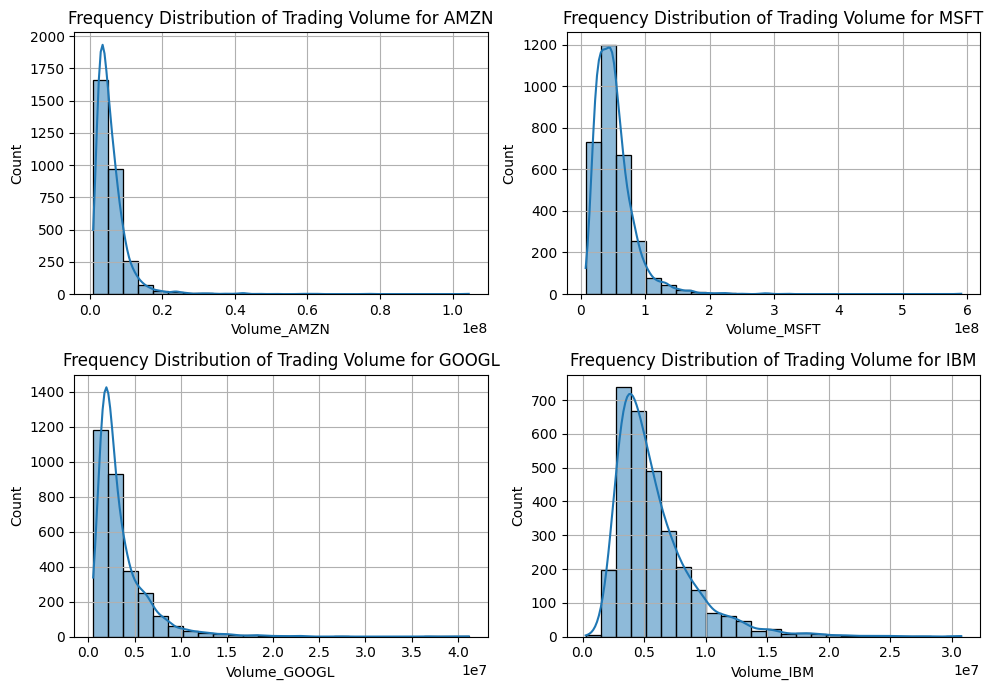

In [29]:
# Frequency distribution of volumes
fig, axes = plt.subplots(2, 2, figsize=(10, 7))
axes = axes.flatten()

comps = ["AMZN", "MSFT", "GOOGL", "IBM"]

for i, comp in enumerate(comps):
    sns.histplot(df[f"Volume_{comp}"], bins=25, kde=True, ax = axes[i])  # Adjust 'bins' as needed
    axes[i].set_title(f"Frequency Distribution of Trading Volume for {comp}")
    axes[i].ticklabel_format(style='sci', axis='x', scilimits=(0,0)) # Format x-axis for large numbers
    axes[i].grid(True)

plt.tight_layout()
plt.show()

##### The volume is very skewed towards the lower ranges, this can be because the higher instances of volume traded in a day would happen very rarely. Lets try to transform it using logarithmic scaling

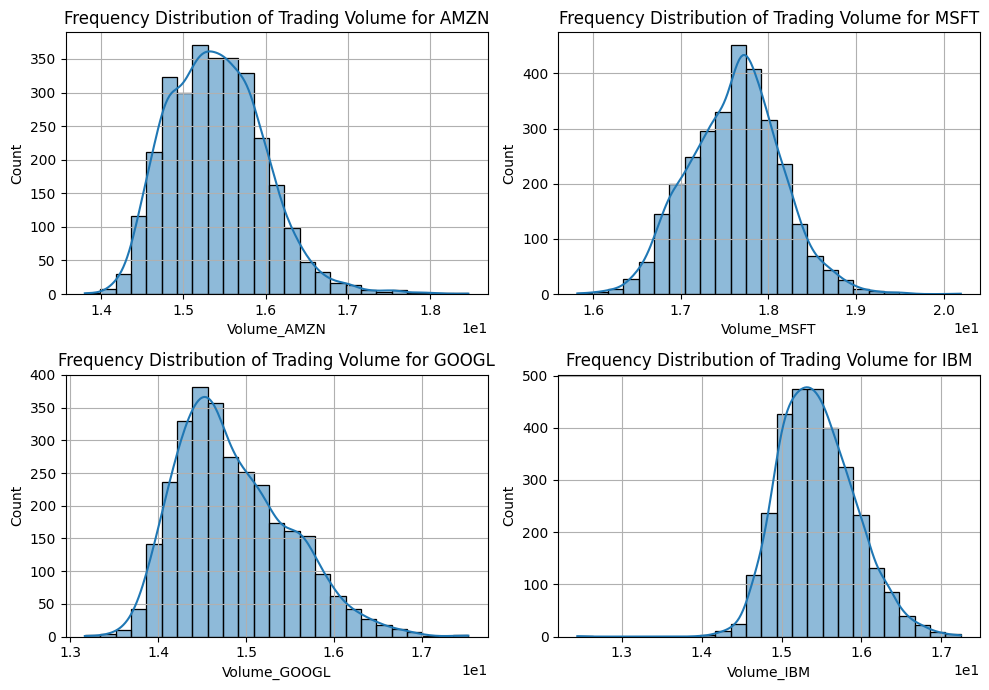

In [30]:
# Frequency distribution of volumes
fig, axes = plt.subplots(2, 2, figsize=(10, 7))
axes = axes.flatten()

for i, comp in enumerate(comps):
    sns.histplot(np.log1p(df[f"Volume_{comp}"]), bins=25, kde=True, ax = axes[i])  # Adjust 'bins' as needed
    axes[i].set_title(f"Frequency Distribution of Trading Volume for {comp}")
    axes[i].ticklabel_format(style='sci', axis='x', scilimits=(0,0)) # Format x-axis for large numbers
    axes[i].grid(True)

plt.tight_layout()
plt.show()

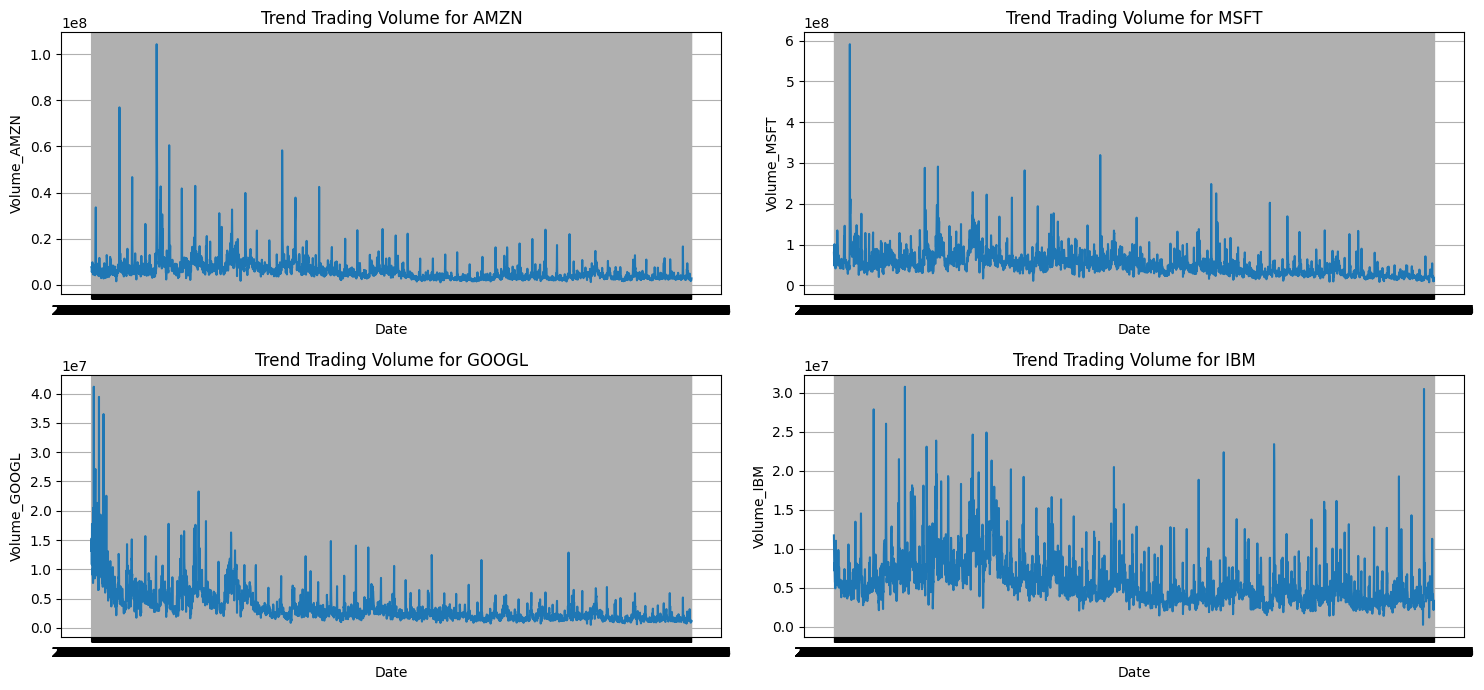

In [31]:
# Stock volume variation over time
fig, axes = plt.subplots(2, 2, figsize=(15, 7))
axes = axes.flatten()

for i, comp in enumerate(comps):
    sns.lineplot(x = df["Date"], y = df[f"Volume_{comp}"], ax = axes[i])
    axes[i].set_title(f"Trend Trading Volume for {comp}")
    axes[i].grid(True)

plt.tight_layout()
plt.show()


#### There isn't much change in volume traded over longer periods. It stays in the same ranges.
#### We do see the range of changes in the volume narrows towards the later years for the companies, this could be due to
- 2008 market crisis, the volume spikes around 2008, which could be due to the financial crisis
- Company maturity, as the companies mature, the volume traded settles down and as the stock prices go up, the amoung of capital required for the similar kind of spikes in the volume increases drastically.

#### Lets plot the trend of Close prices over time
  

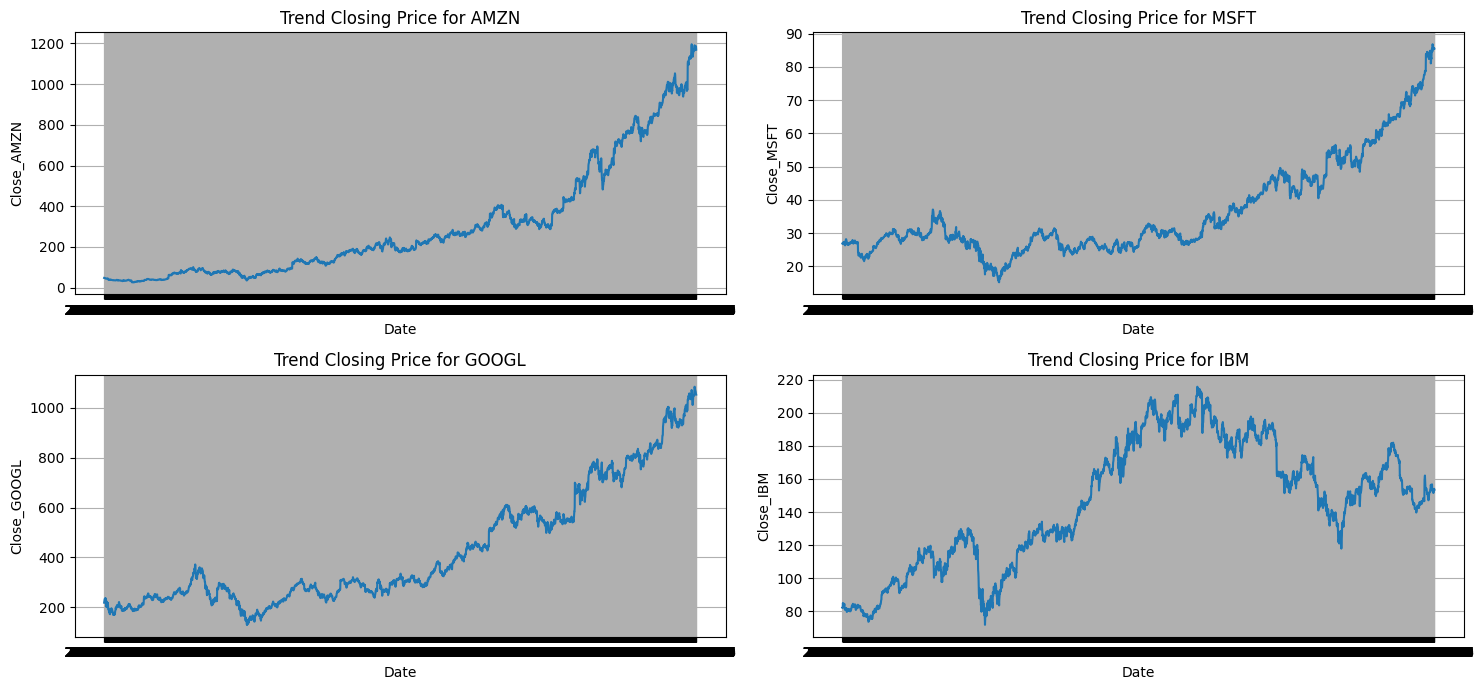

In [32]:
# Stock close price variation over time
fig, axes = plt.subplots(2, 2, figsize=(15, 7))
axes = axes.flatten()

for i, comp in enumerate(comps):
    sns.lineplot(x = df["Date"], y = df[f"Close_{comp}"], ax = axes[i])
    axes[i].set_title(f"Trend Closing Price for {comp}")
    axes[i].grid(True)

plt.tight_layout()
plt.show()

#### We can see that the companies' stock prices have constantly increased over time with some ups and downs along the way. But there is something peculiar about both Volume and Price for IBM, it hasnt done as well as the other companies. It could be due to various reasons, which are not the subject of this analysis, but this would help the model learn generalisation onto companies other than just those that do good over time.

In [33]:
df["Date"] = pd.to_datetime(df['Date'])
df = df.set_index("Date")

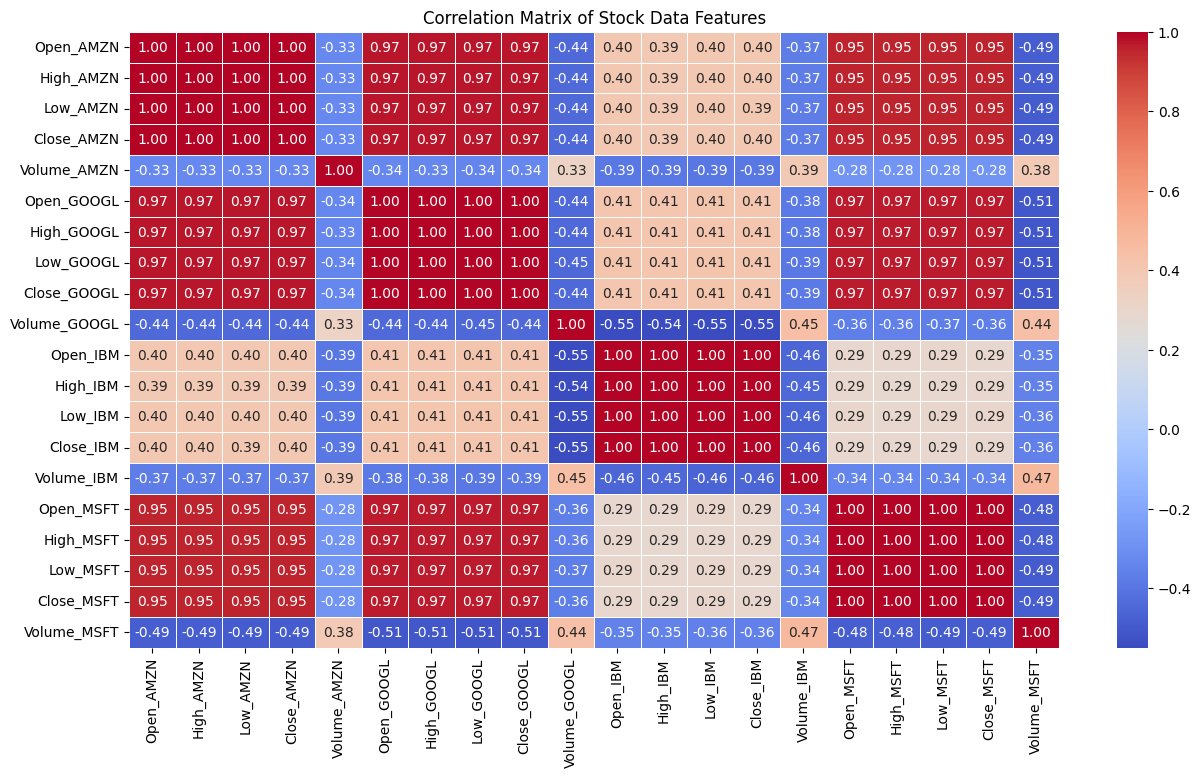

In [34]:
# Analyse correlations
cor_mat = df.corr()

plt.figure(figsize=(15,8))
sns.heatmap(cor_mat, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Stock Data Features')
plt.show()

#### The correlation between different measures of price are perfectly correlated to each other. 
#### The volume is negatively correlated to the price, but we have to keep in mind, that volume will increase in case of either heavy buying or selling. But at the same time Heavy Selling leads to price going down and Heavy Buying leads to an increase in the price. So According to me a negative correlating between Volume and Prices isnt indicative of much

#### Something that can be looked into is, the correlation of prices of one company with the other in the same time frame

#### We can clearly see that for GOOGL, MSFT and AMZN the Correlation among their prices remain almost perfectly positive. But it falls significantly in case of IBM, this can clearly be attributed to the fact that all the other three companies' prices have gone up consistently so there prices' correlation would obviously come out to be highly positive, but IBM hasn't done that, hence the difference in correlation.

### **1.3 Data Processing**

In [35]:
y = [col for col in df if "Close" in col]
y

['Close_AMZN', 'Close_GOOGL', 'Close_IBM', 'Close_MSFT']

In [36]:
#Function for creating window
def target_maker(data):

    for comp in comps:
        #shifting the target column by window number of days
        data[f"Target_Close_{comp}"] = data[f'Close_{comp}'].shift(-1)

    # Separate features (X) and target (y)
    targets = [col for col in data if "Target" in col]
    features = [col for col in data if "Target" not in col]

    #Dropping the rows without target, variables.
    data = data.dropna()
    
    X = data[features].values
    y = data[targets].values # Reshape y to be 2D for scaler

    print(f"\nShape of X (features): {X.shape}")
    print(f"Shape of y (target): {y.shape}")

    return X, y

In [37]:
def windower(data, target, window):
    
    X_sequences, y_sequences = [], []
    
    for i in range(len(data) - window):
        
        # Features for the current sequence 
        X_sequences.append(data[i:(i + window), :])
        
        # Target value for the day immediately following the sequence
        y_sequences.append(target[i + window])
        
    return np.array(X_sequences), np.array(y_sequences)

##### I am going to use MinMaxScaler for well scaling

In [38]:
from sklearn.preprocessing import MinMaxScaler

Define a function that will scale the data.

For scaling, we have to look at the whole length of data to find max/min values or standard deviations and means. If we scale the whole data at once, this will lead to data leakage in the windows. This is not necessarily a problem if the model is trained on the complete data with cross-validation.

One way to scale when dealing with windowed data is to use the `partial_fit()` method.
```
scaler.partial_fit(window)
scaler.transform(window)
```
You may use any other suitable way to scale the data properly. Arrive at a reasonable way to scale your data.

In [39]:
# Define a function that scales the windowed data
# The function takes in the windowed data sets and returns the scaled windows

def scaler(X_train, X_val, X_test, y_train, y_val, y_test):

    num_time_steps = X_train.shape[1]
    num_features = X_train.shape[2]

    #reshaping for scaling
    X_train_reshaped = X_train.reshape(-1, num_features)
    X_val_reshaped = X_val.reshape(-1, num_features)
    X_test_reshaped = X_test.reshape(-1, num_features)

    # Fit scaler on training data only
    
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train_reshaped)
    X_val_scaled = scaler.transform(X_val_reshaped)
    X_test_scaled = scaler.transform(X_test_reshaped)

    scaler_y = MinMaxScaler()
    y_train_scaled = scaler_y.fit_transform(y_train)
    y_val_scaled = scaler_y.transform(y_val)
    y_test_scaled = scaler_y.transform(y_test)

    return X_train_scaled.reshape(-1, num_time_steps, num_features), X_val_scaled.reshape(-1, num_time_steps, num_features), X_test_scaled.reshape(-1, num_time_steps, num_features), y_train_scaled, y_val_scaled, y_test_scaled, scaler_y

In [40]:
def help_caller(data, window):

    #this will give the X and y
    X, y = target_maker(data)

    # I am going to divide the data into train, val and test before I make windows
    train_size = int(len(data) * 0.8)
    val_size = int(len(data) * 0.1)
    
    X_train, X_val, X_test = X[:train_size], X[train_size:train_size + val_size], X[train_size + val_size:]
    y_train, y_val, y_test = y[:train_size], y[train_size:train_size + val_size], y[train_size + val_size:]
    
    print(f"\nTrain set size: {len(X_train)} samples")
    print(f"Validation set size: {len(X_val)} samples")
    print(f"Test set size: {len(X_test)} samples")

    #this will make windows
    X_train_seq, y_train_seq = windower(X_train, y_train, window)
    X_val_seq, y_val_seq = windower(X_val, y_val, window)
    X_test_seq, y_test_seq = windower(X_test, y_test, window)

    return scaler(X_train_seq, X_val_seq, X_test_seq, y_train_seq, y_val_seq, y_test_seq)

We can now use these helper functions to create our training and testing data sets. But first we need to decide on a length of windows. As we are doing time series prediction, we want to pick a sequence that shows some repetition of patterns.

For selecting a good sequence length, some business understanding will help us. In financial scenarios, we can either work with business days, weeks (which comprise of 5 working days), months, or quarters (comprising of 13 business weeks). Try looking for some patterns for these periods.

In [41]:
# Create data instances from the master data frame using decided window size and window stride
window = 7
X_train_scaled, X_val_scaled, X_test_scaled, y_train_scaled, y_val_scaled, y_test_scaled, scaler_y  = help_caller(df, window)



Shape of X (features): (3017, 20)
Shape of y (target): (3017, 4)

Train set size: 2414 samples
Validation set size: 301 samples
Test set size: 302 samples


In [42]:
print(f"\n--- (window ={window}) ---")
print(f"X_train_seq shape: {X_train_scaled.shape} (samples, timesteps, features)")
print(f"y_train_seq shape: {y_train_scaled.shape}")
print(f"X_val_seq shape: {X_val_scaled.shape}")
print(f"y_val_seq shape: {y_val_scaled.shape}")
print(f"X_test_seq shape: {X_test_scaled.shape}")
print(f"y_test_seq shape: {y_test_scaled.shape}")


--- (window =7) ---
X_train_seq shape: (2407, 7, 20) (samples, timesteps, features)
y_train_seq shape: (2407, 4)
X_val_seq shape: (294, 7, 20)
y_val_seq shape: (294, 4)
X_test_seq shape: (295, 7, 20)
y_test_seq shape: (295, 4)


#### Lets see what window size to use

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

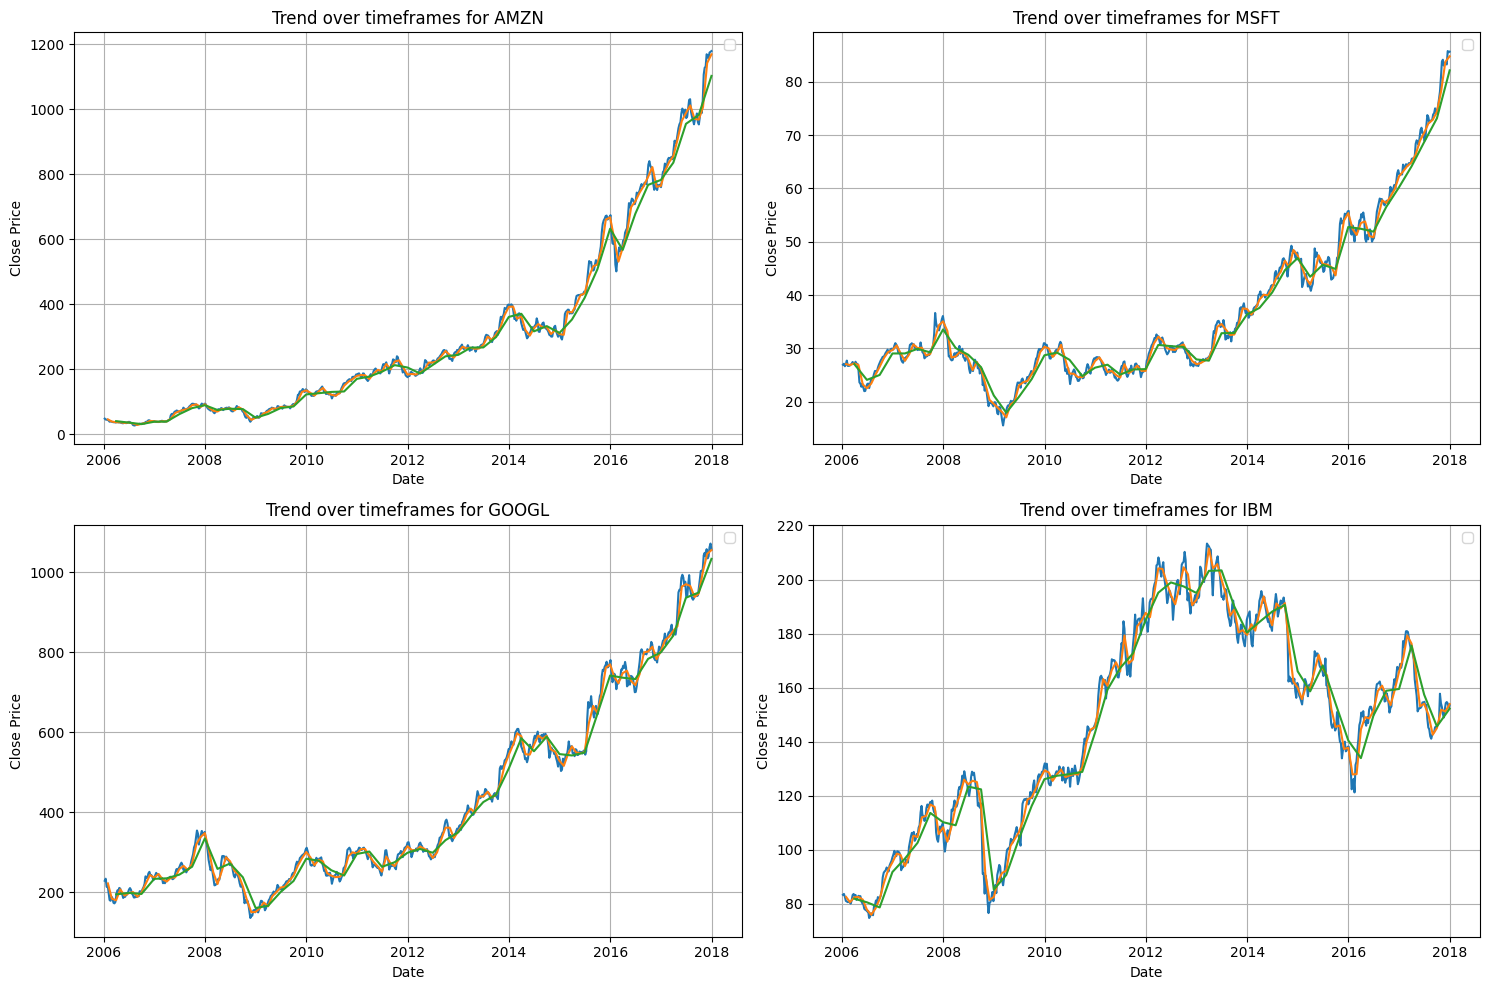

In [43]:
# Stock close price variation over time
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()


for i, comp in enumerate(comps):
    for timeframe in ("W", "M", "Q"):
        resampled = df[f"Target_Close_{comp}"].resample(timeframe).mean()
        sns.lineplot(x=resampled.index, y=resampled.values, ax = axes[i])
        axes[i].set_title(f"Trend over timeframes for {comp}")
        axes[i].set_xlabel("Date")
        axes[i].set_ylabel("Close Price")
        axes[i].grid(True)
        axes[i].legend()
        
plt.tight_layout()
plt.show()

#### We can clearly see that the trends smoothen over different timeframes. the bigger the timeframe the smoother the chart looks. This is so because after zooming out, there isnt much volitility in the market.

#### For the purpose of this analysis, I will try to take the window of a month for the LSTM and 1 week for simple rnn, because simple rnns suffer from vanishing gradient, because that makes sense from an investor point of view as well and will help the model learn how to differentiate between daily volitility over monthly trends

**Check if the training and testing datasets are in the proper format to feed into neural networks.**

### 

## **2 RNN Models**

### **2.1 Simple RNN Model**

In [44]:
!pip install keras_tuner

In [45]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, SimpleRNN, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error, mean_absolute_error
import keras_tuner as kt # Import Keras Tuner

2026-01-12 17:07:02.698352: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768237622.887132      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768237622.937754      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [46]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [47]:
n_features = X_train_scaled.shape[2]
n_targets = 4

In [48]:
def tunable_model_builder(hp):
    model = Sequential()

    num_rnn_layers = hp.Choice('num_rnn_layers', values=[20, 40, 60])

    for i in range(num_rnn_layers):
        # Tune the number of units in each RNN layer
        rnn_units = hp.Int(f'rnn_units_layer_{i}', min_value=64, max_value=256, step=10)
        
        RNN_Layer = SimpleRNN 

        if i == num_rnn_layers - 1: # Last RNN layer
            model.add(RNN_Layer(units=rnn_units, return_sequences=False, input_shape=(window, n_features)))
        
        else: # Intermediate RNN layers
            model.add(RNN_Layer(units=rnn_units, return_sequences=True, input_shape=(window, n_features)))
        
        # Tune dropout rate for each layer
        dropout_rate = hp.Float(f'dropout_rate_layer_{i}', min_value=0.1, max_value=0.5, step=0.1)
        model.add(Dropout(dropout_rate))

    # Output Dense layer for multi-output regression
    model.add(Dense(units=n_targets))

    # Tune the learning rate for the Adam optimizer
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='mean_squared_error')

    return model

Perform hyperparameter tuning to find the optimal network configuration.

In [49]:
# Find an optimal configuration of simple RNN
tuner = kt.RandomSearch(
    tunable_model_builder,
    objective='val_loss',
    max_trials=5,
    executions_per_trial=1,
    directory='my_tuner_dir',
    project_name='stock_rnn_tuning'
)

I0000 00:00:1768237638.105906      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [50]:
early_stopping_tuner = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

tuner.search(
    X_train_scaled,
    y_train_scaled,
    epochs=30,
    batch_size=128,
    validation_data=(X_val_scaled, y_val_scaled),
    callbacks=[early_stopping_tuner],
    verbose=1
)

Trial 5 Complete [00h 01m 08s]
val_loss: 0.3978009819984436

Best val_loss So Far: 0.23337729275226593
Total elapsed time: 00h 08m 04s


In [51]:
# Get the best hyperparameters found
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [52]:
# Find the best configuration based on evaluation metrics
best_model = tuner.get_best_models(num_models=1)[0] 


In [53]:
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 7, 254)         │        69,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 254)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 7, 124)         │        46,996 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 124)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 7, 114)         │        27,246 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 7, 114)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ (None, 7, 84)          │        16,716 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 7, 84)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_4 (SimpleRNN)        │ (None, 7, 234)         │        74,646 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 7, 234)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_5 (SimpleRNN)        │ (None, 7, 144)         │        54,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 7, 144)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_6 (SimpleRNN)        │ (None, 7, 174)         │        55,506 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 7, 174)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_7 (SimpleRNN)        │ (None, 7, 154)         │        50,666 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 7, 154)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_8 (SimpleRNN)        │ (None, 7, 74)          │        16,946 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 7, 74)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_9 (SimpleRNN)        │ (None, 7, 164)         │        39,196 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 7, 164)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_10 (SimpleRNN)       │ (None, 7, 194)         │        69,646 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 7, 194)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_11 (SimpleRNN)       │ (None, 7, 124)         │        39,556 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 7, 124)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_12 (SimpleRNN)       │ (None, 7, 214)         │        72,54

 Total params: 1,171,334 (4.47 MB)

 Trainable params: 1,171,334 (4.47 MB)

 Non-trainable params: 0 (0.00 B)

In [54]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the model

final_early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

history_final = best_model.fit(
    X_train_scaled,
    y_train_scaled,
    epochs=50, # Set a reasonably high number of epochs, EarlyStopping will stop it
    batch_size=128, # Use the optimal batch size found or fixed
    validation_data=(X_val_scaled, y_val_scaled), # Evaluate on the unseen test set during final training
    callbacks=[final_early_stopping],
    verbose=1
)


Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - loss: 0.3533 - val_loss: 0.2115
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.3198 - val_loss: 0.2458
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.3011 - val_loss: 0.2278
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.2758 - val_loss: 0.2533
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.2774 - val_loss: 0.2592
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.2592 - val_loss: 0.2464
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.2490 - val_loss: 0.2905
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.2424 - val_loss: 0.3265
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.2369 - val_loss: 0.3301
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.2173 - val_loss: 0.3218
Epoch 11/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.2150 - val_loss: 0.3293
Epoch 12/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.2

In [55]:
best_model.save('final_model/final_simple_rnn_model.h5')

In [56]:
y_train_pred = best_model.predict(X_train_scaled)
y_val_pred = best_model.predict(X_val_scaled)
y_test_pred = best_model.predict(X_test_scaled)

76/76 ━━━━━━━━━━━━━━━━━━━━ 14s 101ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 380ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [57]:
y_train_pred_original = scaler_y.inverse_transform(y_train_pred)
y_val_pred_original = scaler_y.inverse_transform(y_val_pred)
y_test_pred_original = scaler_y.inverse_transform(y_test_pred)

y_train_gt = scaler_y.inverse_transform(y_train_scaled)
y_val_gt = scaler_y.inverse_transform(y_val_scaled)
y_test_gt = scaler_y.inverse_transform(y_test_scaled)

In [58]:
print(f"Shape of original predictions (y_train_pred_original): {y_train_pred_original.shape}")
print(f"Shape of original actuals (y_test_gt): {y_test_gt.shape}")


Shape of original predictions (y_train_pred_original): (2407, 4)
Shape of original actuals (y_test_gt): (295, 4)


In [59]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [60]:
for i, comp in enumerate(comps):

    # Extract the true and predicted values for the current stock
    y_true_stock = y_test_gt[:, i]
    y_pred_stock = y_test_pred_original[:, i]

    # Calculate R2 score
    r2 = r2_score(y_true_stock, y_pred_stock)
    print(r2)
    
    # Calculate RMSE and MAE
    rmse = np.sqrt(mean_squared_error(y_true_stock, y_pred_stock))
    mae = mean_absolute_error(y_true_stock, y_pred_stock)
    print(rmse, mae)

-23.407474175864195
604.5957348096568 593.8791989787474
-16.221502056933872
31.505695252561576 30.660085334907144
-23.45709625455454
431.04225717814364 423.1623419292903
-0.8000747747096753
15.305873893713027 12.038706865730932


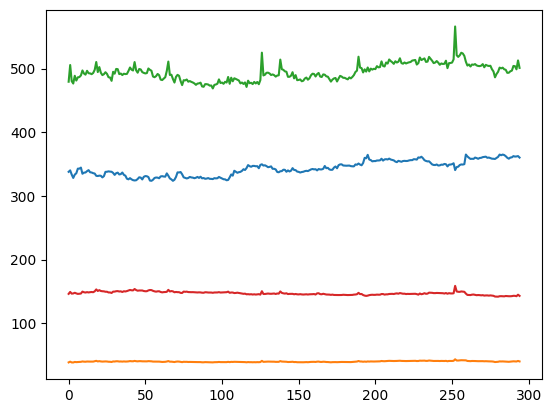

In [61]:
# Predict on the test data and plot
plt.plot(y_test_pred_original)


#### I have tried a lot of different sets of hyperparameter tunings, but the predictions always seem to come out almost same for every data row. I am moving on to advanced Rnn 

### **2.2 Advanced RNN Models**


In this section, we will:
- Create an LSTM or a GRU network
- Tune the network for different hyperparameter values
- View the performance of the optimal model on the test data

In [62]:
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [63]:
input_stock_1 = Input(shape=(window, 5), name='input_stock_1')
input_stock_2 = Input(shape=(window, 5), name='input_stock_2')
input_stock_3 = Input(shape=(window, 5), name='input_stock_3')
input_stock_4 = Input(shape=(window, 5), name='input_stock_4')
all_inputs = [input_stock_1, input_stock_2, input_stock_3, input_stock_4]

def create_bi_lstm_stack(input_tensor, units_l1=128, units_l2=64, dropout_rate=0.3):

    lstm_out = Bidirectional(LSTM(units_l1, return_sequences=True, activation='relu'))(input_tensor)
    
    # Dropout layer for regularization to prevent overfitting [1, 2]
    lstm_out = Dropout(dropout_rate)(lstm_out)

    lstm_out = Bidirectional(LSTM(units_l2, activation='relu'))(lstm_out)
    # Another Dropout layer for further regularization [1, 2]
    lstm_out = Dropout(dropout_rate)(lstm_out)
    return lstm_out

lstm_out_stock_1 = create_bi_lstm_stack(input_stock_1)
lstm_out_stock_2 = create_bi_lstm_stack(input_stock_2)
lstm_out_stock_3 = create_bi_lstm_stack(input_stock_3)
lstm_out_stock_4 = create_bi_lstm_stack(input_stock_4)
concatenated_output = Concatenate()(
    [lstm_out_stock_1, lstm_out_stock_2, lstm_out_stock_3, lstm_out_stock_4]
)
# A Dense (fully connected) layer to process the combined features.
dense_layer = Dense(64, activation='relu')(concatenated_output)
# Dropout for regularization after the dense layer [1, 2]
dense_layer = Dropout(0.3)(dense_layer)

output_layer = Dense(n_targets, activation='linear', name='predicted_prices')(dense_layer)

model = Model(inputs=all_inputs, outputs=output_layer)
model.compile(optimizer=Adam(), loss='mse')

print("--- Model Summary ---")
model.summary()

--- Model Summary ---


Model: "functional_81"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_stock_1       │ (None, 7, 5)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_stock_2       │ (None, 7, 5)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_stock_3       │ (None, 7, 5)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_stock_4       │ (None, 7, 5)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 7, 256)    │    137,216 │ input_stock_1[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 7, 256)    │    137,216 │ input_stock_2[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_4     │ (None, 7, 256)    │    137,216 │ input_stock_3[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_6     │ (None, 7, 256)    │    137,216 │ input_stock_4[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_40          │ (None, 7, 256)    │          0 │ bidirectional[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_42          │ (None, 7, 256)    │          0 │ bidirectional_2[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_44          │ (None, 7, 256)    │          0 │ bidirectional_4[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_46          │ (None, 7, 256)    │          0 │ bidirectional_6[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 128)       │    164,352 │ dropout_40[0][0]  │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 128)       │    164,352 │ dropout_42[0][0]  │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_5     │ (None, 128)       │    164,352 │ dropout_44[0][0]  │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_7     │ (None, 128)       │    164,352 │ dropout_46[0][0]  │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_41          │ (None, 128)       │          0 │ bidirectional_1[

 Total params: 1,239,364 (4.73 MB)

 Trainable params: 1,239,364 (4.73 MB)

 Non-trainable params: 0 (0.00 B)

In [64]:
features_per_stock = 5

# Stock 1 data: features 0-4
stock_data_1 = X_train_scaled[:, :, 0:features_per_stock]
# Stock 2 data: features 5-9
stock_data_2 = X_train_scaled[:, :, features_per_stock:2*features_per_stock]
# Stock 3 data: features 10-14
stock_data_3 = X_train_scaled[:, :, 2*features_per_stock:3*features_per_stock]
# Stock 4 data: features 15-19
stock_data_4 = X_train_scaled[:, :, 3*features_per_stock:4*features_per_stock]

In [65]:
# Stock 1 data: features 0-4
stock_data_1_val = X_val_scaled[:, :, 0:features_per_stock]
# Stock 2 data: features 5-9
stock_data_2_val = X_val_scaled[:, :, features_per_stock:2*features_per_stock]
# Stock 3 data: features 10-14
stock_data_3_val = X_val_scaled[:, :, 2*features_per_stock:3*features_per_stock]
# Stock 4 data: features 15-19
stock_data_4_val = X_val_scaled[:, :, 3*features_per_stock:4*features_per_stock]

In [66]:
 model.fit(
    [stock_data_1, stock_data_2, stock_data_3, stock_data_4],
    y_train_scaled,
    epochs=50,      
    batch_size = 128,
    validation_data=([stock_data_1_val, stock_data_2_val, stock_data_3_val, stock_data_4_val], y_val_scaled),
    verbose = 1
)

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 46s 959ms/step - loss: 0.1175 - val_loss: 0.2186
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0261 - val_loss: 0.0626
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0165 - val_loss: 0.0237
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0127 - val_loss: 0.0187
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0110 - val_loss: 0.0163
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0102 - val_loss: 0.0189
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0095 - val_loss: 0.0193
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0092 - val_loss: 0.0177
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0084 - val_loss: 0.0180
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0084 - val_loss: 0.0163
Epoch 11/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0079 - val_loss: 0.0190
Epoch 12/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0

In [67]:
# Stock 1 data: features 0-4
stock_data_1_test = X_test_scaled[:, :, 0:features_per_stock]
# Stock 2 data: features 5-9
stock_data_2_test = X_test_scaled[:, :, features_per_stock:2*features_per_stock]
# Stock 3 data: features 10-14
stock_data_3_test = X_test_scaled[:, :, 2*features_per_stock:3*features_per_stock]
# Stock 4 data: features 15-19
stock_data_4_test = X_test_scaled[:, :, 3*features_per_stock:4*features_per_stock]

In [68]:
predicted_prices = model.predict([stock_data_1_test, stock_data_2_test, stock_data_3_test, stock_data_4_test])

10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 445ms/step


Plotting the actual vs predicted values

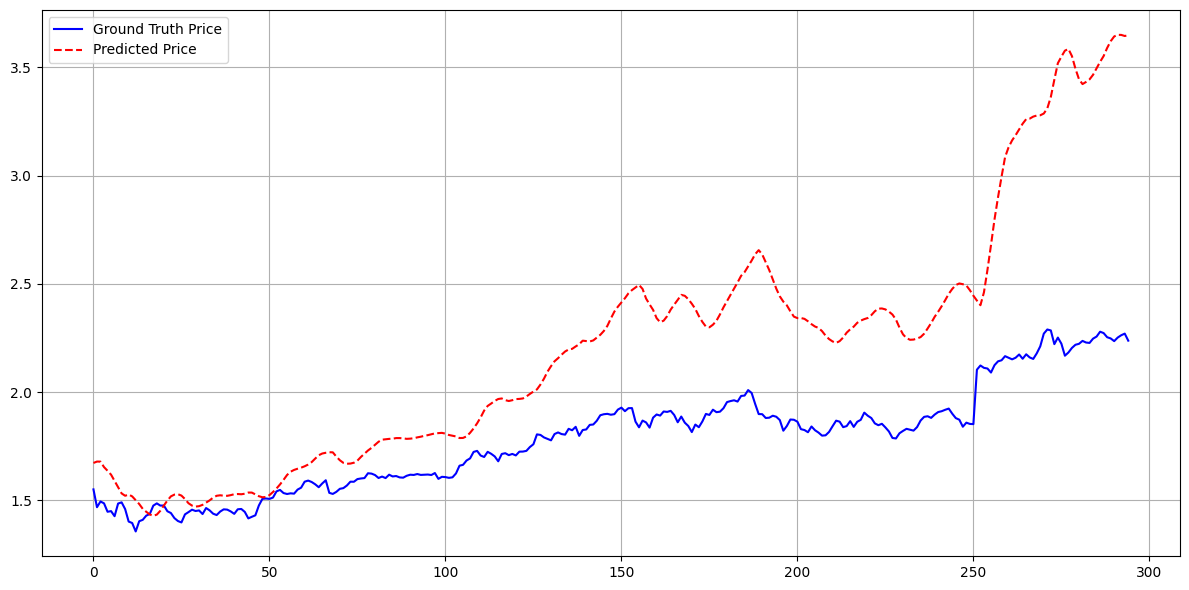

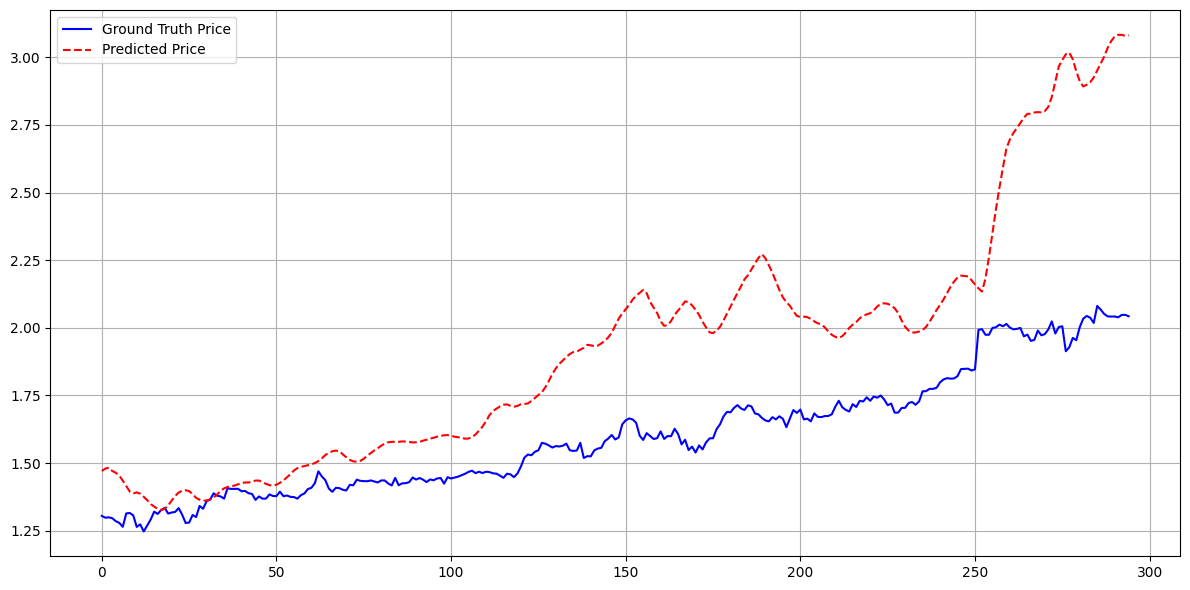

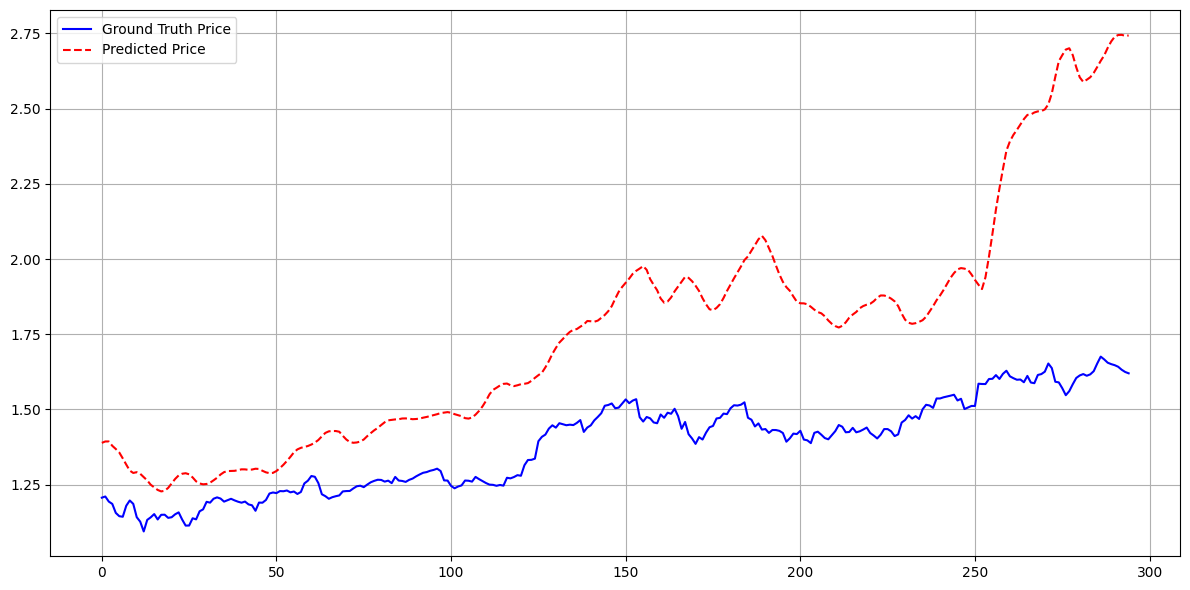

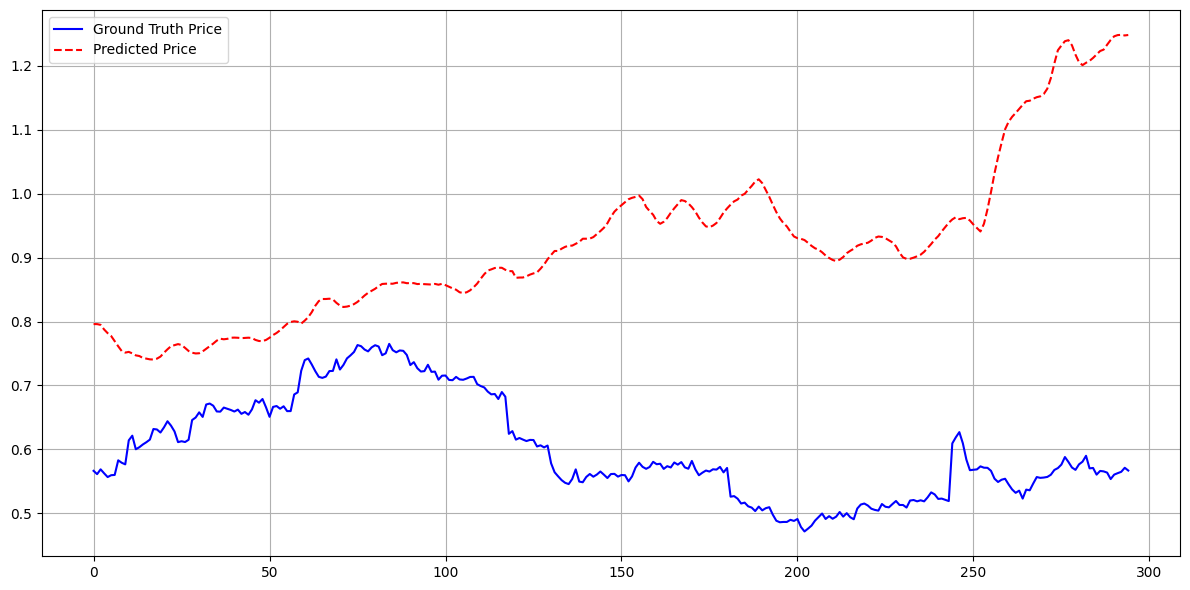

In [69]:
for i in range(4):
    plt.figure(figsize=(12, 6)) # Create a new figure for each plot
    
    # Extract data for the current company
    # predicted_prices[:, i] selects all rows for the i-th column (company)
    company_predicted = predicted_prices[:, i]
    company_ground_truth = y_test_scaled[:, i]
    
    # Plot the ground truth prices
    plt.plot(company_ground_truth, label='Ground Truth Price', color='blue')
    
    # Plot the predicted prices
    plt.plot(company_predicted, label='Predicted Price', color='red', linestyle='--')
    
    # Add titles and labels
    plt.legend() # Display the legend
    plt.grid(True) # Add a grid for better readability
    plt.tight_layout() # Adjust layout to prevent labels from overlapping

# Show all the generated plots
plt.show()

### Conclusion

#### Here the model seems to have learned the trend of the 3 companies that have mostly done well and have generalised that over all outputs. thatswhy we see an upward trend even in the case of IBM (last plot)